<a href="https://colab.research.google.com/github/nelsonbeas33/Datos-Masivos/blob/main/tarea3/tarea3_DatosMasivos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j
!pip install langchain-huggingface

import os
import sys

import findspark
findspark.init()
findspark.find()

from pyspark import SparkContext

from pyspark.sql import SparkSession, DataFrame

from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.sql import functions as F
from pyspark.sql import types as T

from pyspark.ml.feature import StringIndexer, Imputer
from pyspark.ml.feature import VectorAssembler, ChiSqSelector
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,620 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,224 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packa

In [2]:
# Crear una sesión de Spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("IrisDataset").getOrCreate()

# Importar el dataset Iris desde sklearn y convertirlo a un DataFrame de PySpark
from sklearn.datasets import load_iris
import pandas as pd

# Cargar el dataset Iris desde sklearn
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['species'] = iris.target

# Crear un DataFrame de PySpark
df = spark.createDataFrame(iris_df)

# Mostrar las primeras filas del dataset
df.show(5)

# Mostrar el esquema del DataFrame
df.printSchema()


+-----------------+----------------+-----------------+----------------+-------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|species|
+-----------------+----------------+-----------------+----------------+-------+
|              5.1|             3.5|              1.4|             0.2|      0|
|              4.9|             3.0|              1.4|             0.2|      0|
|              4.7|             3.2|              1.3|             0.2|      0|
|              4.6|             3.1|              1.5|             0.2|      0|
|              5.0|             3.6|              1.4|             0.2|      0|
+-----------------+----------------+-----------------+----------------+-------+
only showing top 5 rows

root
 |-- sepal length (cm): double (nullable = true)
 |-- sepal width (cm): double (nullable = true)
 |-- petal length (cm): double (nullable = true)
 |-- petal width (cm): double (nullable = true)
 |-- species: long (nullable = true)



In [3]:
# Estadísticas descriptivas
df.describe().show()


+-------+------------------+------------------+------------------+------------------+------------------+
|summary| sepal length (cm)|  sepal width (cm)| petal length (cm)|  petal width (cm)|           species|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|               150|               150|               150|               150|               150|
|   mean| 5.843333333333332|3.0573333333333337| 3.758000000000001|1.1993333333333331|               1.0|
| stddev|0.8280661279778628|0.4358662849366982|1.7652982332594664|0.7622376689603467|0.8192319205190403|
|    min|               4.3|               2.0|               1.0|               0.1|                 0|
|    max|               7.9|               4.4|               6.9|               2.5|                 2|
+-------+------------------+------------------+------------------+------------------+------------------+



In [4]:
df.groupBy("species").count().show()

+-------+-----+
|species|count|
+-------+-----+
|      0|   50|
|      1|   50|
|      2|   50|
+-------+-----+



In [5]:
# Número de valores nulos por columna
from pyspark.sql.functions import col, sum

df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()


+-----------------+----------------+-----------------+----------------+-------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|species|
+-----------------+----------------+-----------------+----------------+-------+
|                0|               0|                0|               0|      0|
+-----------------+----------------+-----------------+----------------+-------+



In [6]:
# Calcular correlaciones entre columnas numéricas
numeric_columns = ["sepal length (cm)", "sepal width (cm)", "petal length (cm)", "petal width (cm)"]

for col1 in numeric_columns:
    for col2 in numeric_columns:
        if col1 != col2:
            corr = df.stat.corr(col1, col2)
            print(f"Correlación entre {col1} y {col2}: {corr:.2f}")


Correlación entre sepal length (cm) y sepal width (cm): -0.12
Correlación entre sepal length (cm) y petal length (cm): 0.87
Correlación entre sepal length (cm) y petal width (cm): 0.82
Correlación entre sepal width (cm) y sepal length (cm): -0.12
Correlación entre sepal width (cm) y petal length (cm): -0.43
Correlación entre sepal width (cm) y petal width (cm): -0.37
Correlación entre petal length (cm) y sepal length (cm): 0.87
Correlación entre petal length (cm) y sepal width (cm): -0.43
Correlación entre petal length (cm) y petal width (cm): 0.96
Correlación entre petal width (cm) y sepal length (cm): 0.82
Correlación entre petal width (cm) y sepal width (cm): -0.37
Correlación entre petal width (cm) y petal length (cm): 0.96


In [7]:
# Agrupación por especie con estadísticas descriptivas
df.groupBy("species").agg(
    F.mean("sepal length (cm)").alias("mean_sepal_length"),
    F.mean("sepal width (cm)").alias("mean_sepal_width"),
    F.stddev("sepal length (cm)").alias("stddev_sepal_length"),
    F.stddev("sepal width (cm)").alias("stddev_sepal_width")
).show()


+-------+-----------------+------------------+-------------------+------------------+
|species|mean_sepal_length|  mean_sepal_width|stddev_sepal_length|stddev_sepal_width|
+-------+-----------------+------------------+-------------------+------------------+
|      0|5.005999999999999| 3.428000000000001| 0.3524896872134513|0.3790643690962886|
|      1|5.935999999999999|              2.77| 0.5161711470638634|0.3137983233784114|
|      2|6.587999999999998|2.9739999999999998|  0.635879593274432|0.3224966381726375|
+-------+-----------------+------------------+-------------------+------------------+



In [8]:
# Calcular cuartiles y rango intercuartílico
quantiles = df.approxQuantile("sepal length (cm)", [0.25, 0.75], 0.0)
iqr = quantiles[1] - quantiles[0]
lower_bound = quantiles[0] - 1.5 * iqr
upper_bound = quantiles[1] + 1.5 * iqr

# Filtrar valores atípicos
outliers = df.filter((col("sepal length (cm)") < lower_bound) | (col("sepal length (cm)") > upper_bound))
outliers.show()


+-----------------+----------------+-----------------+----------------+-------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|species|
+-----------------+----------------+-----------------+----------------+-------+
+-----------------+----------------+-----------------+----------------+-------+



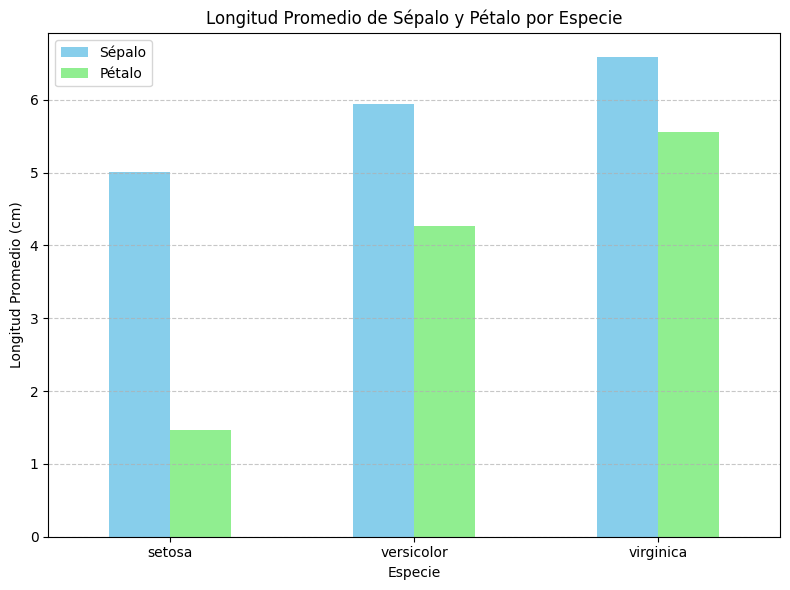

In [9]:
# Agrupar por especie y calcular medias de características relevantes
df_grouped = df.groupBy("species").agg(
    F.mean("sepal length (cm)").alias("mean_sepal_length"),
    F.mean("petal length (cm)").alias("mean_petal_length")
)

# Convertir a Pandas para graficar
df_grouped_pandas = df_grouped.toPandas()

# Mapeo de especies para mejor interpretación
species_map = {0: "setosa", 1: "versicolor", 2: "virginica"}
df_grouped_pandas["species"] = df_grouped_pandas["species"].map(species_map)

# Graficar usando matplotlib
import matplotlib.pyplot as plt

# Configuración de la gráfica
df_grouped_pandas.plot(
    kind="bar",
    x="species",
    y=["mean_sepal_length", "mean_petal_length"],
    figsize=(8, 6),
    color=["skyblue", "lightgreen"]
)
plt.title("Longitud Promedio de Sépalo y Pétalo por Especie")
plt.xlabel("Especie")
plt.ylabel("Longitud Promedio (cm)")
plt.xticks(rotation=0)
plt.legend(["Sépalo", "Pétalo"], loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()
